### Building data pipeline

#### Data Augmentation

In [1]:
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets, models
from torchvision.utils import save_image
from torch.utils.data import DataLoader


image_transform = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size = 256, scale = (0.8, 0.1)),
        transforms.RandomRotation(degrees = 15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size = 224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
        
        
    ]),
    
    'valid': transforms.Compose([
        transforms.Resize(size = 256),
        transforms.CenterCrop(size = 224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                            [0.229, 0.224, 0.225])
        
        
    ]),
    
     'test': transforms.Compose([
        transforms.Resize(size = 256),
        transforms.CenterCrop(size = 224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                            [0.229, 0.224, 0.225])
        
        
    ]),
}

C:\Users\ibrom\Anaconda3\lib\site-packages\torchvision\transforms\transforms.py:622: UserWarning: range should be of kind (min, max)
  warnings.warn("range should be of kind (min, max)")


### Loading the data with DataLoader

In [2]:
#set the train and val directory paths
 
train_dir = 'Train'
val_dir = 'Val'
test_dir = 'Test'

#set batch size

bs = 50

#Number of classes

num_classes = 2

#Load data from folders

data = {
    'train' : datasets.ImageFolder(root = train_dir, transform = image_transform['train']),
    'valid' : datasets.ImageFolder(root = val_dir, transform = image_transform['valid']),
    'test' : datasets.ImageFolder(root = test_dir, transform = image_transform['test']),
}


classes = ('Conjunctivitis', 'Uveitis')

In [3]:
# Let's see the size of our data
train_data_size = len(data['train'])
valid_data_size = len(data['valid'])
test_data_size =  len(data['test'])


In [4]:
#create iterators for 
train_data = DataLoader(data['train'], batch_size = bs, shuffle = True)
valid_data = DataLoader(data['valid'], batch_size = bs, shuffle = True)
test_data = DataLoader(data['test'], batch_size = bs, shuffle = True)

print(train_data_size, valid_data_size, test_data_size)



55 15 22


### Showing our images

In [5]:
from matplotlib import pyplot as plt
import numpy as np


def imdisplay(img):
    img = img/2 + 0.5 #unnormalize the image
    img = img.numpy() #convert to numpy array
    plt.imshow(np.transpose(img, (1,2,0)))
    plt.show()
    
    
    
#get some random training images

dataiter = iter(train_data)
images, labels = dataiter.next()

#display images

imdisplay(torchvision.utils.make_grid(images))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 640x480 with 1 Axes>

### Building the network

In [12]:

class model(nn.Module):
    def __init__(self):
        super(model, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5, padding = 2)
        self.conv2 = nn.Conv2d(32, 64, 5, padding = 2)
        self.conv3 = nn.Conv2d(64, 128, 5, padding = 2)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(128 * 28*28, 120)  #the image dimension becomes 28 * 28 after applying convlution and pooling
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)
        
    def forward(self, x):
        
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        x = x.reshape(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training = self.training)
        x = self.fc3(x)
        return x
    

Model = model()        

### Define a loss function and optimizer

In [13]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(Model.parameters(), lr = 0.001, momentum = 0.9)

### Train the Network

In [14]:
EPOCH = 45

for epoch in range(EPOCH): #iterate over the data multiple times
    running_loss = 0.0
    
    for i, data in enumerate(train_data, 0):
        #get the input; data is a list of [input, labels]
        
        inputs, labels = data
        
        #zero the parameter gradient
        optimizer.zero_grad()
        
        #compute prediction (output) by passing input (x) to the model
        
        output = Model(inputs)
        
        #compute the loss
        loss = criterion(output, labels)
        
        #perform a backward pass
        loss.backward()
        
        #update the parameter
        optimizer.step()
        
        #print loss
        if epoch % 10 == 0:
            print('Epoch:', epoch, 'loss', loss.item()) 

Epoch: 0 loss 0.6964828372001648
Epoch: 0 loss 0.7176311612129211
Epoch: 10 loss 0.6632378101348877
Epoch: 10 loss 0.7306963801383972
Epoch: 20 loss 0.6603241562843323
Epoch: 20 loss 0.6908577084541321
Epoch: 30 loss 0.6818172931671143
Epoch: 30 loss 0.636649489402771
Epoch: 40 loss 0.6851016879081726
Epoch: 40 loss 0.6485974788665771


### Saving the trained model

In [15]:
PATH = './ConjVSuveitis.pth'
torch.save(Model.state_dict(), PATH)

### Testing the Network on test data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


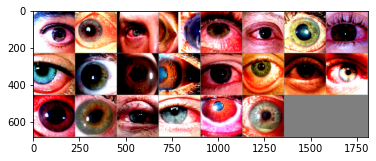

In [16]:
dataiter = iter(test_data)
imgages, labels = dataiter.next()
imdisplay(torchvision.utils.make_grid(images))

print('Groundtruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [17]:
Model.load_state_dict(torch.load(PATH))
outputs = Model(images)

Groundtruth:  Conjunctivitis Conjunctivitis Conjunctivitis Conjunctivitis


In [18]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:  Conjunctivitis Conjunctivitis Conjunctivitis Conjunctivitis


In [19]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_data:
        images, labels = data
        outputs = Model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the  test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the  test images: 54 %


### Make prediction on a completely new image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


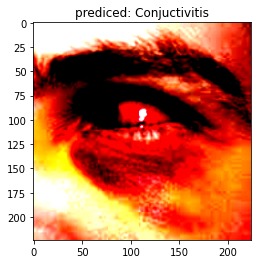

In [20]:
import cv2
from PIL import Image

def MakePrediction(image_path):
    
    #define transform
    transform = transforms.Compose([
        transforms.Resize(size = 256),
        transforms.CenterCrop(size = 224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                            [0.229, 0.224, 0.225])
        
         ])
    #read image; I'm using cv2 incase I need to capture with camera
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    #convert cv2 to PIL and transform
    pil_img = Image.fromarray(img)
    img_final = transform(pil_img)
    
    
    #preprocess the image and make prediction
    batch = torch.unsqueeze(img_final, 0)
    with torch.no_grad():
        Model.eval()
        output = Model(batch)
        _, prediction = torch.max(output, 1)
        
        #print the input image
        predicted_image = img_final/2 + 0.5 #unormalize
        predicted_image = img_final.numpy() #convert to numpy array
        plt.imshow(np.transpose(img_final, (1,2,0)))
        
        
        #print based on predicted class
        
        if prediction == 0:
            plt.title("prediced: Conjuctivitis")
            plt.show()
        elif prediction == 1:
            plt.title("predicted: Uveitis")
            plt.show()
    
    
    
    
    
MakePrediction(r"C:\Users\ibrom\Pictures\blunt trauma.jpg")

Correct Prediction

In [24]:
path = r"C:\Users\ibrom\Desktop\Deep learning\Model\Anterior uveitis\download (1).jpg"
MakePrediction(path)

error: OpenCV(3.4.1) C:\Miniconda3\conda-bld\opencv-suite_1533128839831\work\modules\imgproc\src\color.cpp:11115: error: (-215) scn == 3 || scn == 4 in function cv::cvtColor


Correct prediciton

# Using transfer learning

In [30]:
# Load model
net_model = models.resnet18(pretrained=True)

#freeze model parameters for effective memory use
#for param in net_model.parameters():
#    param.requires_grad = False

# Change the final layer of ResNet18 Model for Transfer Learning

fc_inputs = net_model.fc.in_features  #fully connected input dimension
model.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 2)
                   )


In [31]:
#define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_model.parameters(), lr = 0.001, momentum = 0.9)

In [32]:
EPOCH = 45

for epoch in range(EPOCH): #iterate over the data multiple times
    running_loss = 0.0
    
    for i, data in enumerate(train_data):
        #get the input; data is a list of [input, labels]
        
        inputs, labels = data
        
        #zero the parameter gradient
        optimizer.zero_grad()
        
        #compute prediction (output) by passing input (x) to the model
        
        output = net_model(inputs)
        
        #compute the loss
        loss = criterion(output, labels)
        
        #perform a backward pass
        loss.backward()
        
        #update the parameter
        optimizer.step()
        
        #print loss
        if epoch % 10 == 0:
            print('Epoch:', epoch, 'loss', loss.item())

Epoch: 0 loss 9.15469741821289
Epoch: 0 loss 8.822409629821777
Epoch: 10 loss 0.4151475429534912
Epoch: 10 loss 0.6045306921005249
Epoch: 20 loss 0.22142285108566284
Epoch: 20 loss 0.07156156003475189
Epoch: 30 loss 0.14463381469249725
Epoch: 30 loss 1.666945457458496
Epoch: 40 loss 0.29578912258148193
Epoch: 40 loss 0.31919148564338684


In [33]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_data:
        images, labels = data
        outputs = net_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the  test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the  test images: 90 %


WOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOW

In [45]:
def make_prediction(image_path):
    
    #define transform
    transform = transforms.Compose([
        transforms.Resize(size = 256),
        transforms.CenterCrop(size = 244),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                            [0.229, 0.224, 0.225])
        
         ])
    #read image; I'm using cv2 incase I need to capture with camera
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    #convert cv2 to PIL and transform
    pil_img = Image.fromarray(img)
    img_final = transform(pil_img)
    
    #preprocess the image and make prediction
    batch = torch.unsqueeze(img_final, 0)
    with torch.no_grad():
        Model.eval()
        output = net_model(batch)
        _, prediction = torch.max(output, 1)
        
        #print the input image
        predicted_image = img_final/2 + 0.5 #unormalize
        predicted_image = img_final.numpy() #convert to numpy array
        plt.imshow(np.transpose(img_final, (1,2,0)))
          
        #print based on predicted class
        if prediction == 0:
            plt.title("prediced: Conjuctivitis")
            plt.show()
        elif prediction == 1:
            plt.title("predicted: Uveitis")
            plt.show()
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


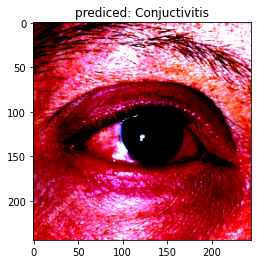

In [46]:
make_prediction(r"C:\Users\ibrom\Pictures\allergic conjunctivitis.jpg")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


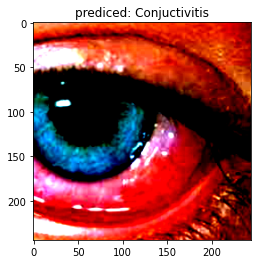

In [47]:
make_prediction(r"C:\Users\ibrom\Pictures\Allergic-conjunctivitis.png.jpg")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


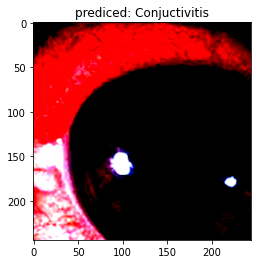

In [48]:
make_prediction(r"C:\Users\ibrom\Pictures\uv1.jpg")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


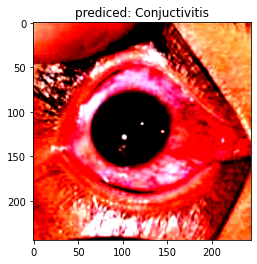

In [49]:
make_prediction(r"C:\Users\ibrom\Pictures\uv2.jpg")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


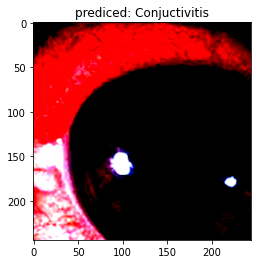

In [53]:
make_prediction(r"C:\Users\ibrom\Pictures\uv1.jpg")